In [236]:
#모듈
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import copy

In [322]:
#파일 불러오기
df=pd.read_csv('./hotel_v2.csv')
df.tail(2)

Grade                                 Hotel Country  Year  Month  \
30582      1  골든 파크 호텔 제주 (Golden Park Hotel Jeju)    대한민국  2022     10   
30583      1  골든 파크 호텔 제주 (Golden Park Hotel Jeju)    대한민국  2022     12   

       stay_day   member        Room type            Date Review Title  \
30582         2   출장 여행객              더블룸  2022년 10월 | 2박         이용후기   
30583         2  나홀로 여행객  룸 (싱글베드 2개, 금연)  2022년 12월 | 2박    가성비 좋은 호텔   

                                         Review Contents  Point  
30582               ['공항과 가깝고 근처에 식당도 있어요 남자 사장님 친절하세요']   10.0  
30583  ['전반적으로 깨끗하고 뚜벅이 여행에 최고좋은 시외버스터미널이 걸어서 5분이라 제주...    8.0

## 2등분 기준
- 평균값(8.5) 
- 7 (리뷰내용 확인결과)

- 중간값(9.2) 사용X

## 3등분 기준
- 3등분(33%, 66%) - (8.4, 9.6) 
- 6, 8
- 

In [297]:
#평점 기준 나누기
np.percentile(df['Point'],q= [50])
np.mean(df['Point'])
np.percentile(df['Point'],q= [10,20,30,40,50,60,70,80,90,100])

array([ 6. ,  7.6,  8. ,  8.8,  9.2,  9.6, 10. , 10. , 10. , 10. ])

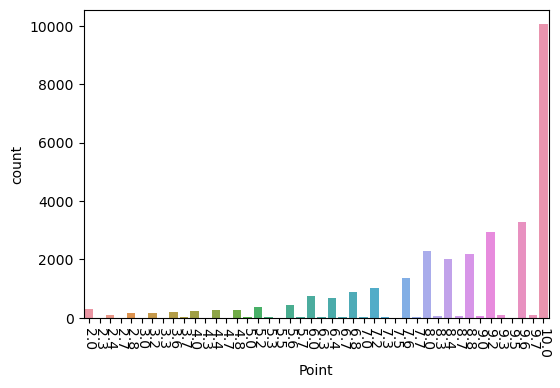

In [276]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Point'])
plt.xticks(rotation=-90)
plt.show()

부정: 11774 긍정: 18810


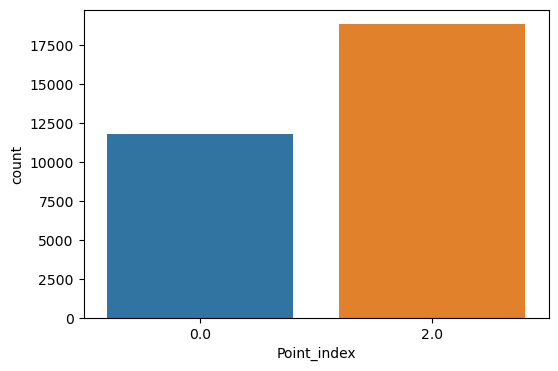

In [294]:
#std 평점 기준값 (2등분)
std = 8.5  #기준값 설정
df["Point_index"] = [2. if point >= std else 0. for point in df["Point"]]


df_pos = df[df['Point_index']==2] #긍정리뷰 데이터프레임
df_neg = df[df['Point_index']==0] #부정리뷰 데이터프레임

#인덱스별 분포 확인
print("부정:",len(df_neg),"긍정:",len(df_pos))
plt.figure(figsize=(6,4))
sns.countplot(x=df['Point_index'])
plt.show()

부정: 2569 중립: 11464 긍정: 16551


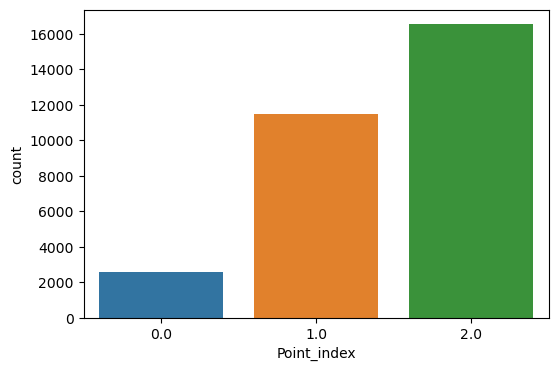

In [312]:
#std2 평점 기준값 (3등분)
high = 9  #이상 긍정
low = 6  #미만 부정
df2=copy.deepcopy(df)

df2.loc[df2['Point']>=high, 'Point_index'] = 2
df2.loc[(df2['Point']<high) & (df2['Point']>=low), 'Point_index'] = 1
df2.loc[df2['Point']<low, 'Point_index'] = 0

df2_pos = df2[df2['Point_index']==2] #긍정리뷰 데이터프레임
df2_cen = df2[df2['Point_index']==1] #중립리뷰 데이터프레임
df2_neg = df2[df2['Point_index']==0] #부정리뷰 데이터프레임

#인덱스별 분포 확인

print("부정:",len(df2_neg),"중립:", len(df2_cen),"긍정:",len(df2_pos))
plt.figure(figsize=(6,4))
sns.countplot(x=df2['Point_index'])
plt.show()

In [143]:
# 말뭉치 생성 (평점 2등분)

review_corpus=''.join(df['Review Contents'].tolist()) #전체 리뷰
review_corpus_pos=''.join(df_pos['Review Contents'].tolist()) #긍정 리뷰
review_corpus_neg=''.join(df_neg['Review Contents'].tolist()) #부정 리뷰


In [ ]:
# 말뭉치 생성 (평점 3등분)

review_corpus=''.join(df2['Review Contents'].tolist()) #전체 리뷰
review_corpus_pos=''.join(df2_pos['Review Contents'].tolist()) #긍정 리뷰
review_corpus_cen=''.join(df2_cen['Review Contents'].tolist()) #부정 리뷰
review_corpus_neg=''.join(df2_neg['Review Contents'].tolist()) #부정 리뷰

In [169]:
#실행 하지말기
#특수문자 제거 + 한글자 키워드 제거 에러나옴(해결필요)
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]') 
    tagger = Okt()
    result = hangul.sub('', text)  # 특수문자 제거
    text_clean = tagger.morphs(result)
    text_clean = [x for x in text_clean if len(x) > 1]  # 한글자 키워드 제거
    count_text_clean = Counter(text_clean)
    return count_text_clean

# 형태소 추출  

In [174]:
#평점 2등분 기준 - 형태소 추출(한번만 실행하면됨) *추가작업은 불용문자에서

hangul = re.compile('[^ ㄱ-ㅣ 가-힣]') 
morphs_tagger = Okt()

#전체
result1 = hangul.sub('', review_corpus)
text_clean1 = morphs_tagger.morphs(result1) #특수문자 제거
morphs = [x for x in text_clean1 if len(x) > 1]  # 한글자 키워드 제거
count_morphs = Counter(morphs)

#긍정
result2 = hangul.sub('', review_corpus_pos)
text_clean2 = morphs_tagger.morphs(result2) #특수문자 제거
orphs_pos = [x for x in text_clean2 if len(x) > 1]  # 한글자 키워드 제거
count_morphs_pos = Counter(orphs_pos)


#부정
result3 = hangul.sub('', review_corpus_neg)
text_clean3 = morphs_tagger.morphs(result3) #특수문자 제거
morphs_neg = [x for x in text_clean3 if len(x) > 1]  # 한글자 키워드 제거
count_morphs_neg = Counter(morphs_neg)


In [ ]:
#평점 3등분 기준 - 형태소 추출(한번만 실행하면됨) *추가작업은 불용문자에서

hangul = re.compile('[^ ㄱ-ㅣ 가-힣]') 
morphs_tagger = Okt()

#전체
result1 = hangul.sub('', review_corpus)
text_clean1 = morphs_tagger.morphs(result1) #특수문자 제거
morphs = [x for x in text_clean1 if len(x) > 1]  # 한글자 키워드 제거
count_morphs = Counter(morphs)

#긍정
result2 = hangul.sub('', review_corpus_pos)
text_clean2 = morphs_tagger.morphs(result2) #특수문자 제거
morphs_pos = [x for x in text_clean2 if len(x) > 1]  # 한글자 키워드 제거
count_morphs_pos = Counter(morphs_pos)

#중립
result7 = hangul.sub('', review_corpus_cen)
text_clean7 = morphs_tagger.morphs(result7) #특수문자 제거
morphs_cen = [x for x in text_clean7 if len(x) > 1]  # 한글자 키워드 제거
count_morphs_cen = Counter(morphs_cen)

#부정
result3 = hangul.sub('', review_corpus_neg)
text_clean3 = morphs_tagger.morphs(result3) #특수문자 제거
morphs_neg = [x for x in text_clean3 if len(x) > 1]  # 한글자 키워드 제거
count_morphs_neg = Counter(morphs_neg)

# 명사 추출

In [207]:
#평점 2등분 기준 - 명사 추출

hangul = re.compile('[^ ㄱ-ㅣ 가-힣]') 
nouns_tagger = Okt()

#전체
result4 = hangul.sub('', review_corpus)
text_clean4 = nouns_tagger.nouns(result4) #특수문자 제거
text_clean4 = [x for x in text_clean4 if len(x) > 1]  # 한글자 키워드 제거
count_nouns = Counter(text_clean4)

#긍정
result5 = hangul.sub('', review_corpus_pos)
text_clean5 = morphs_tagger.nouns(result5) #특수문자 제거
nouns_pos = [x for x in text_clean5 if len(x) > 1]  # 한글자 키워드 제거
count_nouns_pos = Counter(nouns_pos)

#부정
result6 = hangul.sub('', review_corpus_neg)
text_clean6 = morphs_tagger.nouns(result6) #특수문자 제거
nouns_neg = [x for x in text_clean6 if len(x) > 1]  # 한글자 키워드 제거
count_nouns_neg = Counter(nouns_neg)


In [ ]:
#평점 2등분 기준 - 명사 추출명사 추출

hangul = re.compile('[^ ㄱ-ㅣ 가-힣]') 
nouns_tagger = Okt()

#전체
result4 = hangul.sub('', review_corpus)
text_clean4 = nouns_tagger.nouns(result4) #특수문자 제거
nouns = [x for x in text_clean4 if len(x) > 1]  # 한글자 키워드 제거
count_nouns = Counter(nouns)

#긍정
result5 = hangul.sub('', review_corpus_pos)
text_clean5 = morphs_tagger.nouns(result5) #특수문자 제거
nouns_pos = [x for x in text_clean5 if len(x) > 1]  # 한글자 키워드 제거
count_nouns_pos = Counter(nouns_pos)

#중립
result8 = hangul.sub('', review_corpus_cen)
text_clean8 = morphs_tagger.nouns(result8) #특수문자 제거
nouns_cen = [x for x in text_clean8 if len(x) > 1]  # 한글자 키워드 제거
count_nouns_cen = Counter(nouns_cen)


#부정
result6 = hangul.sub('', review_corpus_neg)
text_clean6 = morphs_tagger.nouns(result6) #특수문자 제거
nouns_neg = [x for x in text_clean6 if len(x) > 1]  # 한글자 키워드 제거
count_nouns_neg = Counter(nouns_neg)

0

# 불용문자 제거시 사용

In [214]:
korean_stopword='./stopwords.txt'

with open(korean_stopword, encoding='utf-8') as f:
    stopwords=f.readlines()
stopwords[:5]

['\n', '아\n', '휴\n', '아이구\n', '아이쿠\n']

In [383]:
# 주로 사용하기 시작할 코드

# 불용어 (https://www.ranks.nl/stopwords/korean)

korean_stopword='./stopwords.txt'

with open(korean_stopword, encoding='utf-8') as f:
    stopwords=f.readlines()

stoplist=[x.strip() for x in stopwords]
print(stopwords[:10])
print(stoplist[:10])

#불용어 추가
# add_list=['제주도','호텔','숙소','가성','성비','대비','이용','제주','역시','생각','상태','다만','바로','느낌','신라','직원','가격','위치','시설','조식','객실','그냥']

# for word in add_list:
#     stoplist.append(word)

# print(stoplist[-10:])

['\n', '아\n', '휴\n', '아이구\n', '아이쿠\n', '아이고\n', '어\n', '나\n', '우리\n', '저희\n']
['', '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희']


In [385]:
count_morphs_pos['호텔']

8533

In [197]:
#불용문자 제거(형태소)
count_morphs_stop = Counter({x : count_morphs[x] for x in count_morphs if x not in stoplist})
count_morphs_pos_stop = Counter({x : count_morphs_pos[x] for x in count_morphs_pos if x not in stoplist})
count_morphs_neg_stop = Counter({x : count_morphs_neg[x] for x in count_morphs_neg if x not in stoplist})


# 3등분시 사용
# count_morphs_cen_stop = Counter({x : count_morphs_cen[x] for x in count_morphs_cen if x not in stoplist})

In [264]:
#불용문자 제거(명사)
count_nouns_stop = Counter({x : count_nouns[x] for x in count_nouns if x not in stoplist})
count_nouns_pos_stop = Counter({x : count_nouns_pos[x] for x in count_nouns_pos if x not in stoplist})
count_nouns_neg_stop = Counter({x : count_nouns_neg[x] for x in count_nouns_neg if x not in stoplist})

# 3등분시 사용
# count_nouns_cen_stop = Counter({x : count_nouns_cen[x] for x in count_nouns_cen if x not in stoplist})

# 워드 클라우드 

In [262]:
#문자 수 확인용 필요한내용 주석 해제 사용

# count_morphs.most_common(20)
# count_morphs_pos.most_common(20)
# count_morphs_neg.most_common(20)
# count_morphs_stop.most_common(20)
# count_morphs_pos_stop.most_common(20)
# count_morphs_neg_stop.most_common(20)



## 형태소 워드클라우드

In [205]:
#전체 형태소

wc=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc2=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc3=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')

gen_morphs=wc.generate_from_frequencies(count_morphs)
gen_morphs_pos=wc2.generate_from_frequencies(count_morphs_pos)
gen_morphs_neg=wc3.generate_from_frequencies(count_morphs_neg)

In [263]:
fig, axs = plt.subplots(2,2, figsize=(150,120))
axs[0][0].imshow(gen_morphs_pos)
axs[0][1].imshow(gen_morphs_neg)
axs[1][0].imshow(gen_morphs)
plt.show()

In [109]:
#불용문자 추가 형태소 워드클라우드
wc4=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=600, height=400, scale=2.0, max_font_size=250, background_color='white')
wc5=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=600, height=400, scale=2.0, max_font_size=250, background_color='white')
wc6=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=600, height=400, scale=2.0, max_font_size=250, background_color='white')
gen_morphs_stop=wc4.generate_from_frequencies(count_morphs_stop)
gen_morphs_pos_stop=wc5.generate_from_frequencies(count_morphs_pos_stop)
gen_morphs_neg_stop=wc6.generate_from_frequencies(count_morphs_neg_stop)

In [115]:
fig, axs = plt.subplots(2,2, figsize=(100,120))
axs[0][0].imshow(gen_morphs_pos_stop)
axs[0][1].imshow(gen_morphs_neg_stop)
axs[1][0].imshow(gen_morphs_stop)
plt.show()

## 명사 워드클라우드

In [ ]:
#문자 수 확인용 필요한내용 주석 해제 사용


# count_nouns.most_common(20)
# count_nouns_pos.most_common(20)
# count_nouns_neg.most_common(20)
# count_nouns_stop.most_common(20)
# count_nouns_pos_stop.most_common(20)
# count_nouns_neg_stop.most_common(20)

In [213]:
#전체 명사

wc7=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc8=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc9=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')

gen_nouns=wc7.generate_from_frequencies(count_nouns)
gen_nouns_pos=wc8.generate_from_frequencies(count_nouns_pos)
gen_nouns_neg=wc9.generate_from_frequencies(count_nouns_neg)

fig, axs = plt.subplots(2,2, figsize=(150,120))
axs[0][0].imshow(gen_nouns_pos)
axs[0][1].imshow(gen_nouns_neg)
axs[1][0].imshow(gen_nouns)
plt.show()

In [ ]:
# 명사 불용문자 추가

wc10=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc11=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc12=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')

gen_nouns_stop=wc10.generate_from_frequencies(count_nouns_stop)
gen_nouns_pos_stop=wc11.generate_from_frequencies(count_nouns_pos_stop)
gen_nouns_neg_stop=wc12.generate_from_frequencies(count_nouns_neg_stop)

fig, axs = plt.subplots(2,2, figsize=(150,120))
axs[0][0].imshow(gen_nouns_pos_stop)
axs[0][1].imshow(gen_nouns_neg_stop)
axs[1][0].imshow(gen_nouns_stop)
plt.show()

# 머신러닝 

In [337]:
#파일 불러오기
df=pd.read_csv('./hotel_v2.csv')
df.tail(2)

Grade                                 Hotel Country  Year  Month  \
30582      1  골든 파크 호텔 제주 (Golden Park Hotel Jeju)    대한민국  2022     10   
30583      1  골든 파크 호텔 제주 (Golden Park Hotel Jeju)    대한민국  2022     12   

       stay_day   member        Room type            Date Review Title  \
30582         2   출장 여행객              더블룸  2022년 10월 | 2박         이용후기   
30583         2  나홀로 여행객  룸 (싱글베드 2개, 금연)  2022년 12월 | 2박    가성비 좋은 호텔   

                                         Review Contents  Point  
30582               ['공항과 가깝고 근처에 식당도 있어요 남자 사장님 친절하세요']   10.0  
30583  ['전반적으로 깨끗하고 뚜벅이 여행에 최고좋은 시외버스터미널이 걸어서 5분이라 제주...    8.0

부정: 11774 긍정: 0


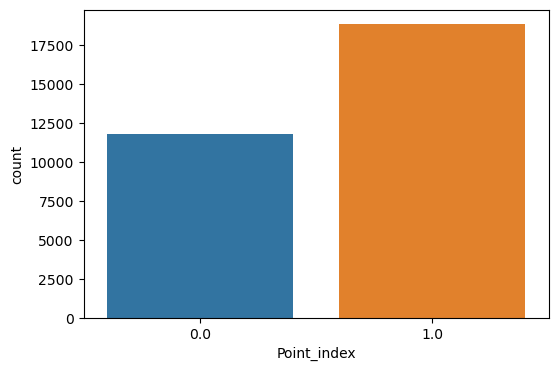

In [369]:
#std 평점 기준값 (2등분)
std = 8.5  #기준값 설정
df["Point_index"] = [1. if point >= std else 0. for point in df["Point"]]


df_pos = df[df['Point_index']==2] #긍정리뷰 데이터프레임
df_neg = df[df['Point_index']==0] #부정리뷰 데이터프레임

#인덱스별 분포 확인
print("부정:",len(df_neg),"긍정:",len(df_pos))
plt.figure(figsize=(6,4))
sns.countplot(x=df['Point_index'])
plt.show()

In [339]:
df['Review Contents'] = df['Review Contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.head(5)

C:\Users\Jeong\AppData\Local\Temp\ipykernel_21948\3862035606.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review Contents'] = df['Review Contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


Grade                         Hotel Country  Year  Month  stay_day  \
0      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      5         3   
1      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2019      8         1   
2      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      4         1   
3      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      3         1   
4      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      2         2   

            member Room type           Date           Review Title  \
0          나홀로 여행객   스탠다드 트윈  2021년 5월 | 3박              기대보다 좋았어요   
1        커플/2인 여행객    객실정보없음  2019년 8월 | 1박                수영장이용!!   
2        커플/2인 여행객   프리미엄 더블  2021년 4월 | 1박         메종 글래드 너무 좋았어요   
3  유아/아동 동반 가족 여행객   스탠다드 트윈  2021년 3월 | 1박  5성급 호텔을 저렴한가격에 누릴수있는곳   
4        커플/2인 여행객   스탠다드 트윈  2021년 2월 | 2박          4계절이 다른 도심속호텔   

                                     Review Contents  Point  Point_index  
0  시설이 낡았다는 후기를 보고 별 기대없이 갔는데 박동안 행복하게 보내고 왔습니다 새...   10.0          2.0  
1  첫날 공항이랑 가까워서 이용했구요 수영장이 화면보다 작아요 많이 수영장보고 선택한건...   10.0          2.0  
2  메종 글래드는 처음이였는데 제주 여행 마지막날 다른 숙소에서 벌레를 보고나서 바로 ...   10.0          2.0  
3  로비 직원분들 친절하시고 레스토랑과 카페 분위기가 너무 좋았습니다 특히 가격도 호텔...   10.0          2.0  
4  제주를 매달 한번씩은 가고있는데 메종은 거의 계절마다 방문하는거 같습니다 항상 친절...   10.0          2.0

In [344]:
tag = Okt()
df['morphs'] = df['Review Contents'].apply(lambda x : tag.morphs(x))
df['nouns'] = df['Review Contents'].apply(lambda x : tag.nouns(x))
df.head()

Grade                         Hotel Country  Year  Month  stay_day  \
0      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      5         3   
1      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2019      8         1   
2      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      4         1   
3      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      3         1   
4      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      2         2   

            member Room type           Date           Review Title  \
0          나홀로 여행객   스탠다드 트윈  2021년 5월 | 3박              기대보다 좋았어요   
1        커플/2인 여행객    객실정보없음  2019년 8월 | 1박                수영장이용!!   
2        커플/2인 여행객   프리미엄 더블  2021년 4월 | 1박         메종 글래드 너무 좋았어요   
3  유아/아동 동반 가족 여행객   스탠다드 트윈  2021년 3월 | 1박  5성급 호텔을 저렴한가격에 누릴수있는곳   
4        커플/2인 여행객   스탠다드 트윈  2021년 2월 | 2박          4계절이 다른 도심속호텔   

                                     Review Contents  Point  Point_index  \
0  시설이 낡았다는 후기를 보고 별 기대없이 갔는데 박동안 행복하게 보내고 왔습니다 새...   10.0          2.0   
1  첫날 공항이랑 가까워서 이용했구요 수영장이 화면보다 작아요 많이 수영장보고 선택한건...   10.0          2.0   
2  메종 글래드는 처음이였는데 제주 여행 마지막날 다른 숙소에서 벌레를 보고나서 바로 ...   10.0          2.0   
3  로비 직원분들 친절하시고 레스토랑과 카페 분위기가 너무 좋았습니다 특히 가격도 호텔...   10.0          2.0   
4  제주를 매달 한번씩은 가고있는데 메종은 거의 계절마다 방문하는거 같습니다 항상 친절...   10.0          2.0   

                                              morphs  \
0  [시설, 이, 낡았다는, 후기, 를, 보고, 별, 기대, 없이, 갔는데, 박동, 안...   
1  [첫날, 공항, 이랑, 가까워서, 이용, 했구요, 수영장, 이, 화면, 보다, 작아...   
2  [메종, 글, 래, 드는, 처음, 이, 였는데, 제주, 여행, 마지막, 날, 다른,...   
3  [로비, 직원, 분들, 친절하시고, 레스토랑, 과, 카페, 분위기, 가, 너무, 좋...   
4  [제주, 를, 매달, 한번, 씩, 은, 가고있는데, 메, 종은, 거의, 계절, 마다...   

                                               nouns  
0  [시설, 후기, 보고, 별, 기대, 박동, 안, 새, 느낌, 침대, 햇, 다음, 숙...  
1  [첫날, 공항, 이용, 수영장, 화면, 수영장, 보고, 선택, 사람, 수기, 베드,...  
2  [메종, 글, 처음, 제주, 여행, 마지막, 날, 다른, 숙소, 벌레, 바로, 예약...  
3  [로비, 직원, 레스토랑, 카페, 분위기, 가격, 호텔, 내, 위치, 더, 일반, ...  
4  [제주, 매달, 한번, 메, 종은, 거의, 계절, 방문, 항상, 직원, 먼저, 인사...

In [ ]:
#특수문자 및 불용문자 제거

import string
string.punctuation

#형태소
df['morphs2'] = df['morphs'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['morphs2'] = df['morphs2'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

#명사
df['nouns2'] = df['nouns'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['nouns2'] = df['nouns2'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

## 형태소 워드클라우드

In [378]:
df['morphs2'] = df['morphs2'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['nouns2'] = df['nouns2'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df.head()

Grade                         Hotel Country  Year  Month  stay_day  \
0      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      5         3   
1      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2019      8         1   
2      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      4         1   
3      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      3         1   
4      5  메종 글래드 제주 (Maison Glad Jeju)    대한민국  2021      2         2   

            member Room type           Date           Review Title  \
0          나홀로 여행객   스탠다드 트윈  2021년 5월 | 3박              기대보다 좋았어요   
1        커플/2인 여행객    객실정보없음  2019년 8월 | 1박                수영장이용!!   
2        커플/2인 여행객   프리미엄 더블  2021년 4월 | 1박         메종 글래드 너무 좋았어요   
3  유아/아동 동반 가족 여행객   스탠다드 트윈  2021년 3월 | 1박  5성급 호텔을 저렴한가격에 누릴수있는곳   
4        커플/2인 여행객   스탠다드 트윈  2021년 2월 | 2박          4계절이 다른 도심속호텔   

                                     Review Contents  Point  Point_index  \
0  시설이 낡았다는 후기를 보고 별 기대없이 갔는데 박동안 행복하게 보내고 왔습니다 새...   10.0          1.0   
1  첫날 공항이랑 가까워서 이용했구요 수영장이 화면보다 작아요 많이 수영장보고 선택한건...   10.0          1.0   
2  메종 글래드는 처음이였는데 제주 여행 마지막날 다른 숙소에서 벌레를 보고나서 바로 ...   10.0          1.0   
3  로비 직원분들 친절하시고 레스토랑과 카페 분위기가 너무 좋았습니다 특히 가격도 호텔...   10.0          1.0   
4  제주를 매달 한번씩은 가고있는데 메종은 거의 계절마다 방문하는거 같습니다 항상 친절...   10.0          1.0   

                                              morphs  \
0  [시설, 이, 낡았다는, 후기, 를, 보고, 별, 기대, 없이, 갔는데, 박동, 안...   
1  [첫날, 공항, 이랑, 가까워서, 이용, 했구요, 수영장, 이, 화면, 보다, 작아...   
2  [메종, 글, 래, 드는, 처음, 이, 였는데, 제주, 여행, 마지막, 날, 다른,...   
3  [로비, 직원, 분들, 친절하시고, 레스토랑, 과, 카페, 분위기, 가, 너무, 좋...   
4  [제주, 를, 매달, 한번, 씩, 은, 가고있는데, 메, 종은, 거의, 계절, 마다...   

                                               nouns  \
0  [시설, 후기, 보고, 별, 기대, 박동, 안, 새, 느낌, 침대, 햇, 다음, 숙...   
1  [첫날, 공항, 이용, 수영장, 화면, 수영장, 보고, 선택, 사람, 수기, 베드,...   
2  [메종, 글, 처음, 제주, 여행, 마지막, 날, 다른, 숙소, 벌레, 바로, 예약...   
3  [로비, 직원, 레스토랑, 카페, 분위기, 가격, 호텔, 내, 위치, 더, 일반, ...   
4  [제주, 매달, 한번, 메, 종은, 거의, 계절, 방문, 항상, 직원, 먼저, 인사...   

                                             morphs2  \
0  시 설     낡 았 다 는   후 기     보 고   별   기 대   없   ...   
1  첫 날   공 항   랑   까 워 서   용   했 요   수 장     화 면 ...   
2  메 종   글   래   드 는   처 음     였 는 데   주   행   마 ...   
3  비   직 원   분   친 절 시 고   레 스 토 랑     카 페   분 위 ...   
4  주     달   한 번   씩   은   고 있 는 데   메   종 은   거 ...   

                                              nouns2  
0  시 설   후 기   보 고   별   기 대   박 동   안   새   느 낌 ...  
1  첫 날   공 항   용   수 장   화 면   수 장   보 고   선 택   ...  
2  메 종   글   처 음   주   행   마 지 막   날   다 른   숙 소 ...  
3  비   직 원   레 스 토 랑   카 페   분 위 기   격   호 텔   내 ...  
4  주   달   한 번   메   종 은   거   계 절   방 문   항 상   ...

## 형태소 워드클라우드

In [370]:
# 벡터화 

from sklearn.feature_extraction.text import CountVectorizer

X1 = df['morphs2']
X2 = df['nouns2']
y = df['Point_index']

vectorizer = CountVectorizer(lowercase=False)
X1 = vectorizer.fit_transform(X1)
X2 = vectorizer.fit_transform(X2)

# Train data와 test data로 나누기

from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y, test_size = 0.2, random_state=13)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y, test_size = 0.2, random_state=13)

### 나이브 베이즈  

In [371]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

model.fit(X1_train, y1_train)
pred = model.predict(X1_test)

### 로지스틱 회귀 

In [373]:
model2 = LogisticRegression()
model2.fit(X2_train,y2_train)
y_pred_test = model2.predict(X2_test)

c:\Users\Jeong\miniconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 성능 테스트

In [377]:
df.to_csv('./ML_process.csv')

In [375]:
# 분류기 성능 return 

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix
from sklearn import metrics


def get_clf_eval(y_test,pred):
    acc= accuracy_score(y_test, pred)
    pre=precision_score(y_test, pred)
    re=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    auc=roc_auc_score(y_test, pred)

    return acc, pre, re,f1, auc


def print_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test,pred)
    acc,pre,re,f1,auc = get_clf_eval(y_test, pred)

    print('=> confusion matrix')
    print(confusion)
    print('===============')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    print('Recall : {0:.4f}, F1 : {1:.4f}, Auc:{2:.4f}'.format(re,f1,auc))


#나이브베이즈 성능
print_clf_eval(y1_test, pred)

#로지스틱 성능
print_clf_eval(y2_test, y_pred_test)

=> confusion matrix
[[1131 1228]
 [ 337 3421]]
Accuracy : 0.7442, Precision : 0.7359
Recall : 0.9103, F1 : 0.8138, Auc:0.6949
=> confusion matrix
[[1054 1305]
 [ 506 3252]]
Accuracy : 0.7039, Precision : 0.7136
Recall : 0.8654, F1 : 0.7822, Auc:0.6561
